# جداسازی معنایی با یادگیری انتقالی در مدل یونت با بک بن ریسنت34 و وزنهای از پیش اموزش دیده ایمیج نت

In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras

import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
#import keras 
from tensorflow.keras.utils import img_to_array

from keras.utils import normalize
from keras.metrics import MeanIoU

Segmentation Models: using `tf.keras` framework.


داده های مدل در ادرس زیر قابل دانلود است
https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
  https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
    شامل 7393 تصویر 

In [11]:


input_dir = "d3/images/"
target_dir = "d3/annotations/trimaps/"
img_size = (128, 128)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:5], target_img_paths[:5]):
    print(input_path, "|", target_path)
input_path=[i for i in input_img_paths[:300]]
target_path=[i for i in target_img_paths[:300] ]

Number of samples: 7390
d3/images/Abyssinian_1.jpg | d3/annotations/trimaps/Abyssinian_1.png
d3/images/Abyssinian_10.jpg | d3/annotations/trimaps/Abyssinian_10.png
d3/images/Abyssinian_100.jpg | d3/annotations/trimaps/Abyssinian_100.png
d3/images/Abyssinian_101.jpg | d3/annotations/trimaps/Abyssinian_101.png
d3/images/Abyssinian_102.jpg | d3/annotations/trimaps/Abyssinian_102.png


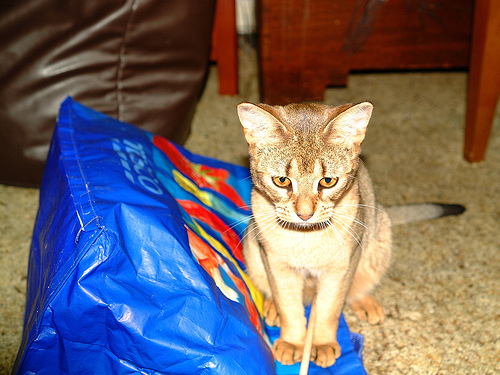

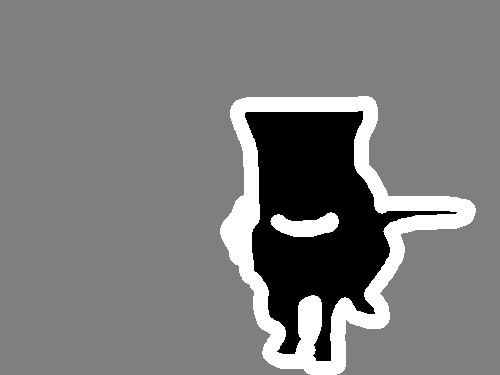

In [12]:
from IPython.display import Image, display
from tensorflow.keras.utils import load_img
from PIL import ImageOps
t=7
# Display input image #7
display(Image(filename=input_img_paths[t]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[t]))
display(img)

In [21]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, )
            y[j] = img
            #np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
        return x, y

In [22]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [23]:
######################################################
#Reused parameters in all models

num_classes=3
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


In [24]:
X_train =train_gen[0]
y_train=train_gen[1]
# X_train=[np.asarray(x).astype(np.float32) for x in X_train  ]
# y_train=[np.asarray(x).astype(np.float32) for x in y_train  ]

In [25]:
x_valid=val_gen[0]
y_valid=val_gen[1]
# x_valid=[np.asarray(x).astype(np.float32) for x in x_valid  ]
# y_valid=[np.asarray(x).astype(np.float32) for x in y_valid ]

# ساخت مدل

In [26]:
########################################################################
###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train = preprocess_input1(X_train)
#X_test1 = preprocess_input1(X_test)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=num_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
#model1.compile(optim, total_loss, metrics=metrics)

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

#print(model1.summary())

print('ok')

ok


In [27]:
tf.config.experimental_run_functions_eagerly(True)
model1.fit(train_gen, 
        
        batch_size=8,
        epochs=15,
        verbose=1,
        validation_data=val_gen)


model1.save('res34_backbone_50epochs.hdf5')

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


C:\Users\reza\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/15
199/199 [==============================] - 13027s 65s/step - loss: 7.7278 - iou_score: 0.2504 - f1-score: 0.2924 - val_loss: 12.2558 - val_iou_score: 0.2843 - val_f1-score: 0.3336
Epoch 2/15
199/199 [==============================] - 12931s 65s/step - loss: 8.6644 - iou_score: 0.3506 - f1-score: 0.3515 - val_loss: 10.3506 - val_iou_score: 0.3172 - val_f1-score: 0.3598
Epoch 3/15
199/199 [==============================] - 12923s 65s/step - loss: 9.4156 - iou_score: 0.3909 - f1-score: 0.3738 - val_loss: 10.4670 - val_iou_score: 0.3981 - val_f1-score: 0.3844
Epoch 4/15
199/199 [==============================] - 12991s 65s/step - loss: 10.0358 - iou_score: 0.4084 - f1-score: 0.3863 - val_loss: 10.2944 - val_iou_score: 0.3563 - val_f1-score: 0.3824
Epoch 5/15
199/199 [==============================] - 12932s 65s/step - loss: 10.6054 - iou_score: 0.4205 - f1-score: 0.3975 - val_loss: 10.6316 - val_iou_score: 0.3937 - val_f1-score: 0.3923
Epoch 6/15
199/199 [=======================

# پیش بینی 

In [34]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model1.predict(val_gen)



31/31 [==============================] - 465s 15s/step


# تست و ارزیابی

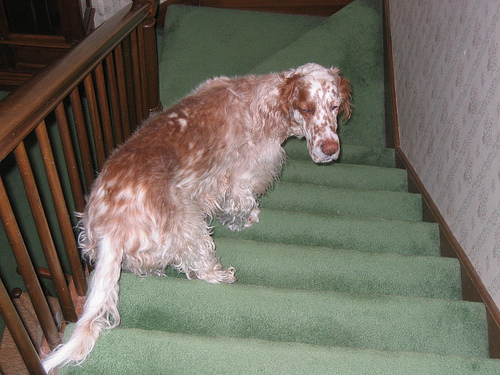

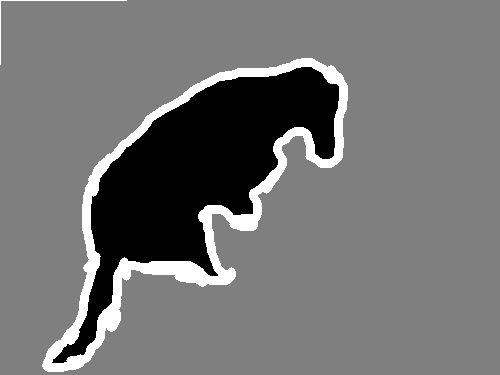

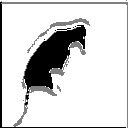

In [35]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 11

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.
